In [14]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

In [15]:
SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
y = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  # 这里是污染数据固定不变当成训练数据

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96

loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse
x = x.to(device)
y = y.to(device)#把数据都载入到device上

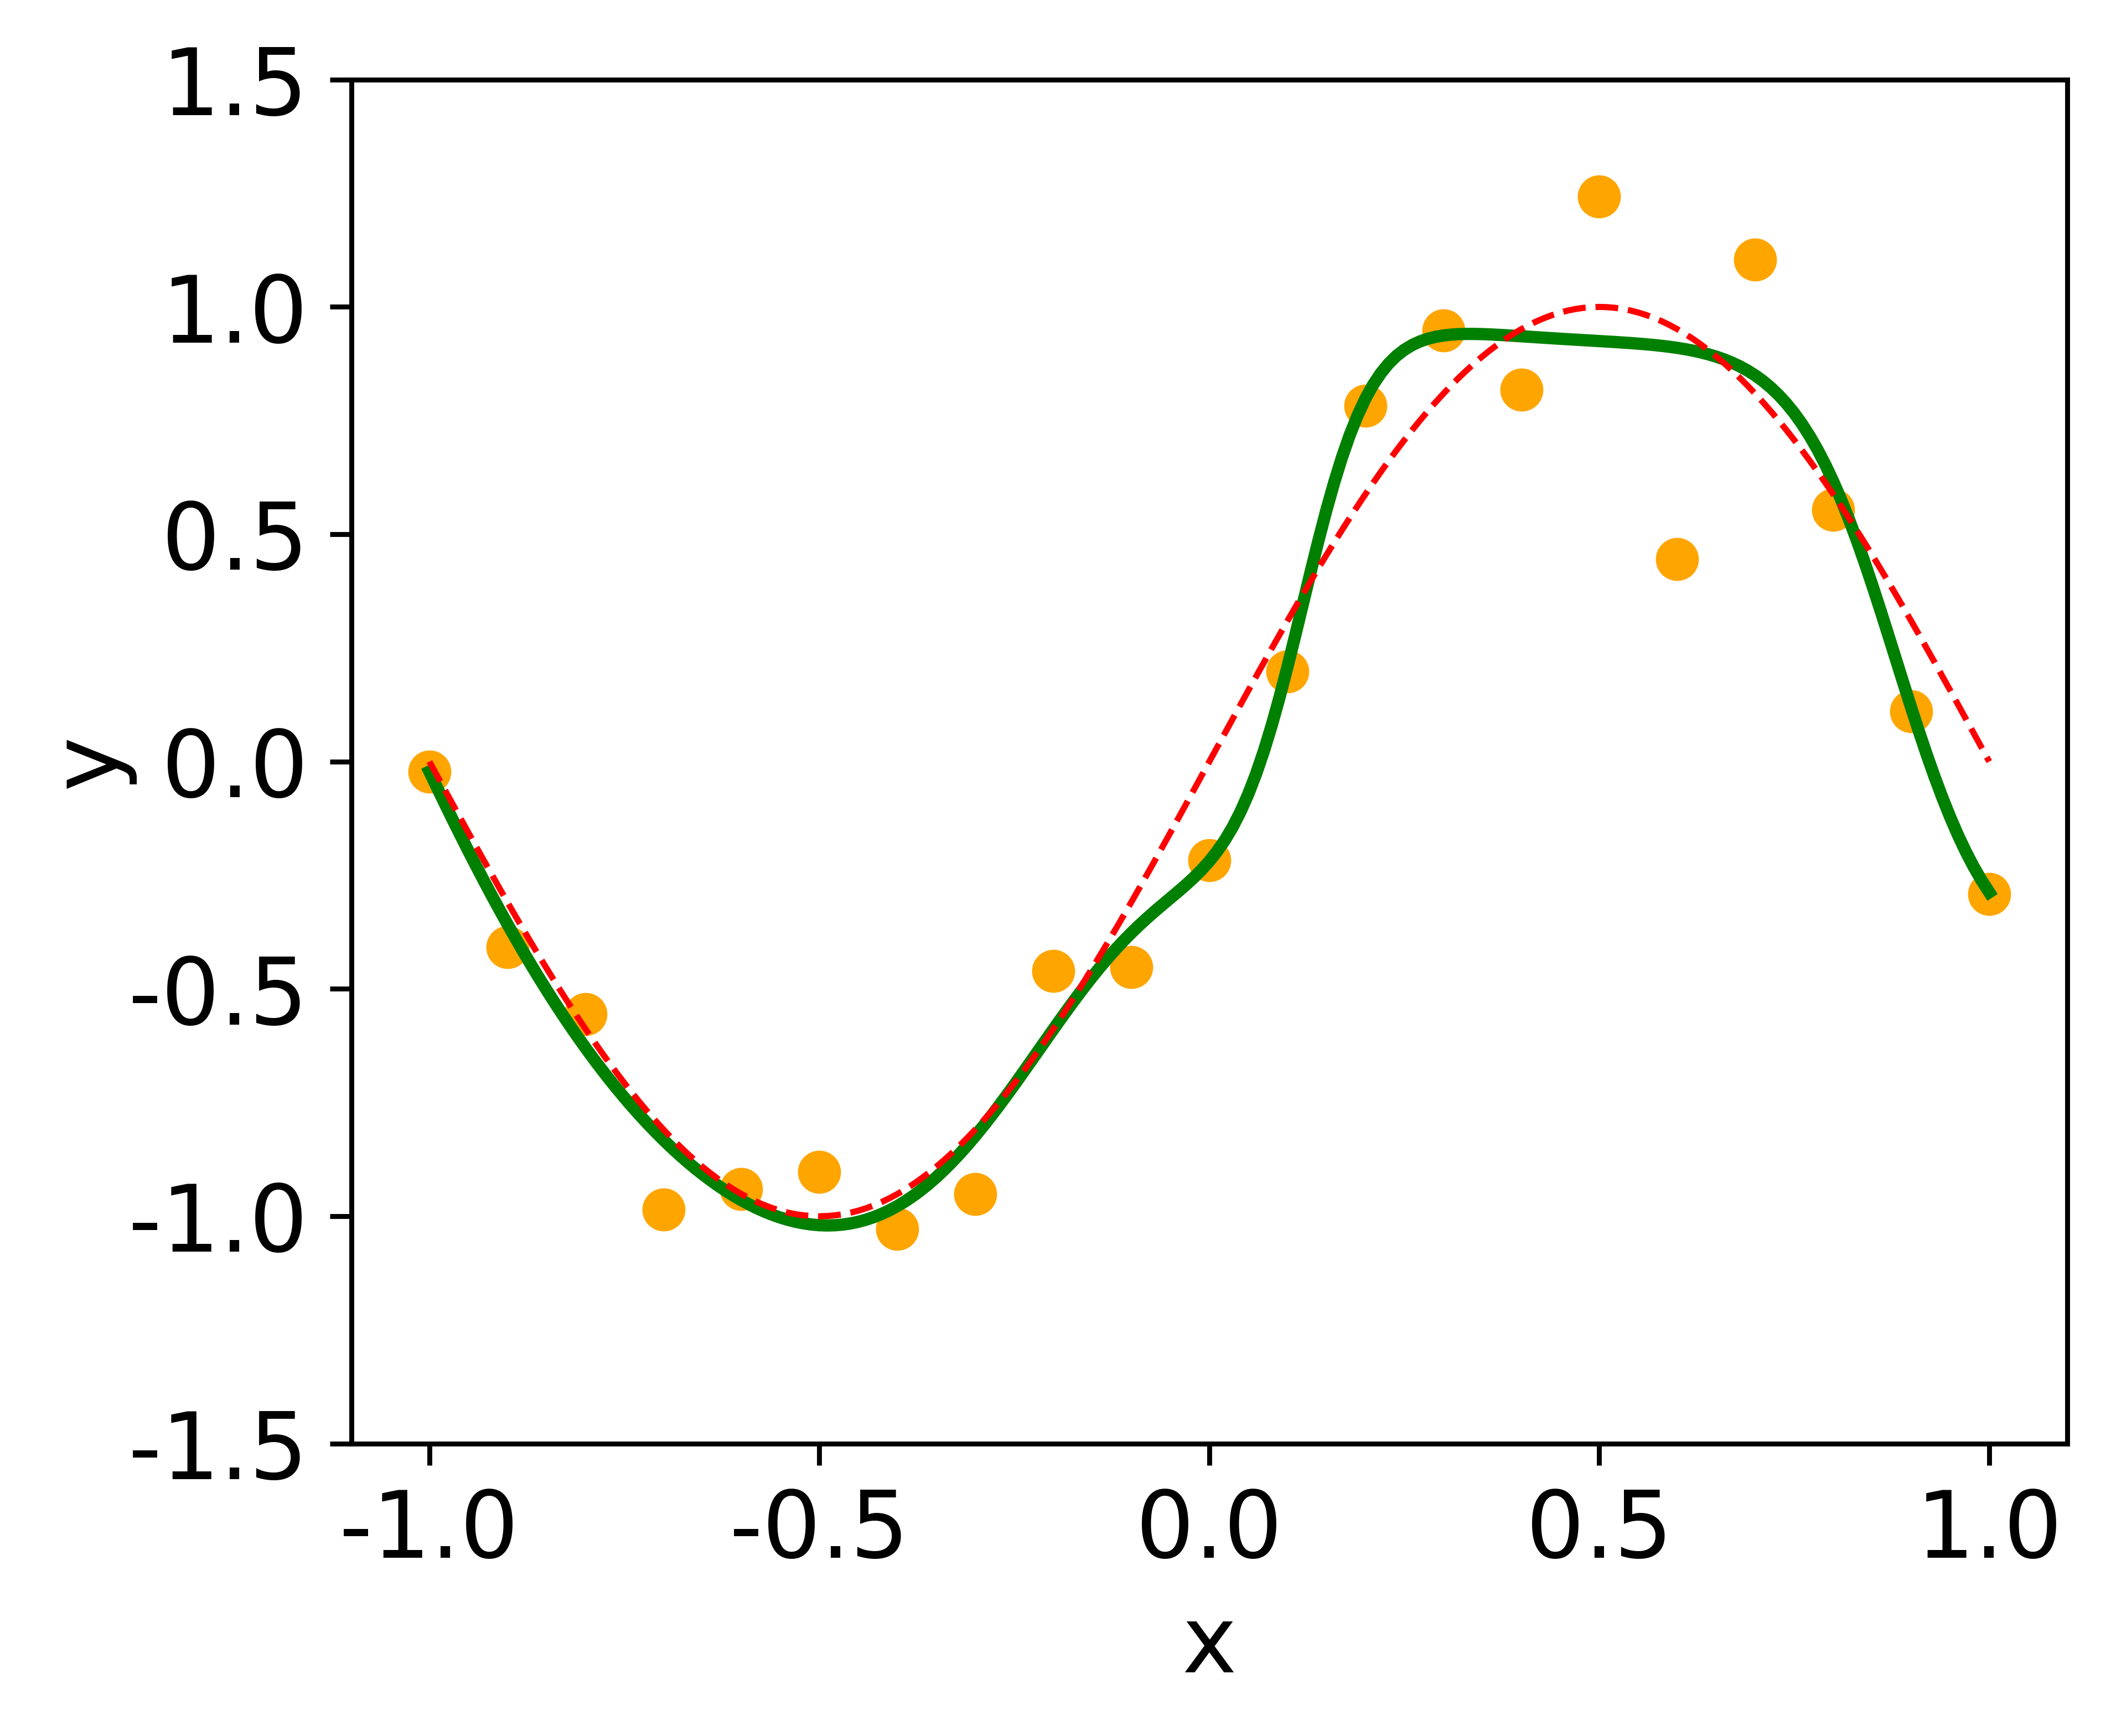

In [16]:
epoch = 20000#训练次数2万次
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录验证时函数的loss
std_dev=0.001#权系数上加噪声均方根大小
for t in range(epoch):
   
    prediction = net(x)  # 网络前向过程
    loss = loss_func(prediction, y) # 计算loss，通过prediction和y的差来计算mse
    para0[t] = loss.data
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    # 在更新参数之前，为每个参数添加高斯噪声
    for param in net.parameters():
        noise = torch.randn_like(param) * std_dev  # 标准高斯噪声乘以标准差
        param.data.add_(noise)
        
    optimizer.step()        # 更新参数！
##########################
#画出结果
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

tensor([0.5898, 0.5709, 0.5615,  ..., 0.0233, 0.0232, 0.0231])


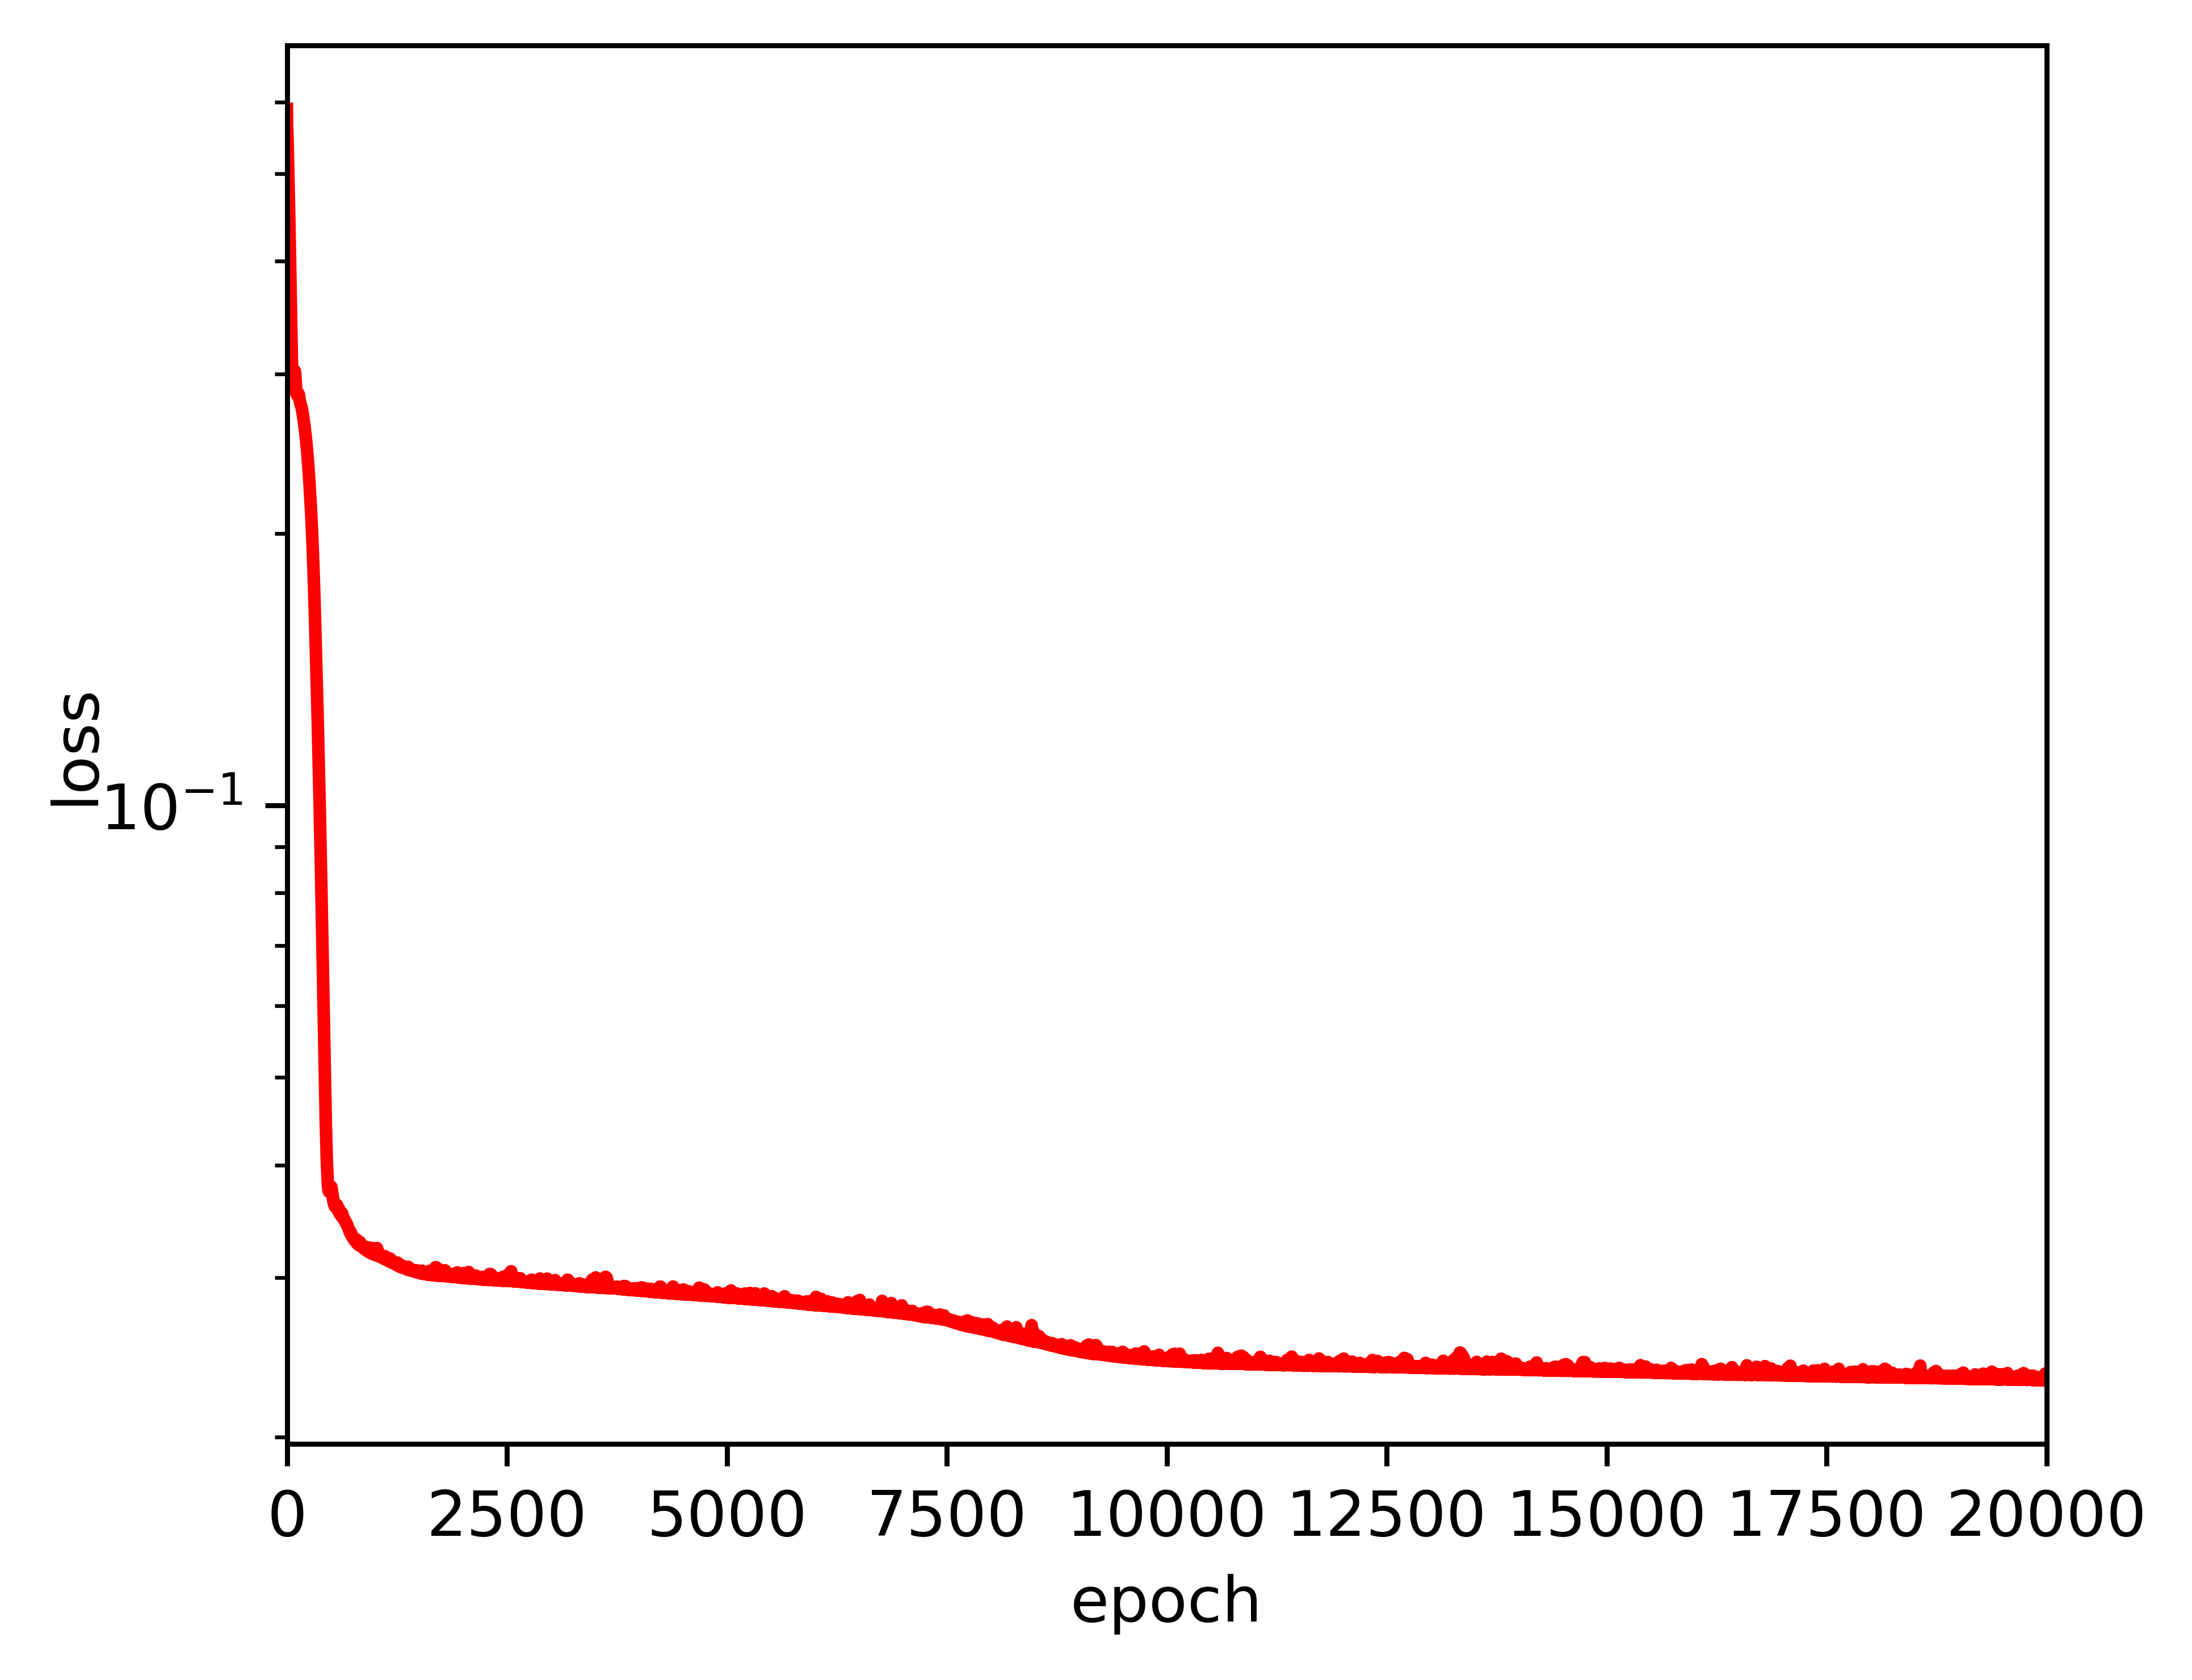

In [17]:
print(para0)#训练的MSE
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=10)
ax.set_xlabel('epoch', fontsize=10)
ax.set_ylabel('loss', fontsize=10, labelpad=-1)
ax.set_xlim(0, 20000)
ax.set_yscale('log')  # 设置y轴为对数坐标

ax.plot(para0.data.numpy(), 'r-', lw=2)
plt.show()

In [19]:
#看起来有效果
##############测试
SEED = 4321

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xx = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)#这里我们采样数目不一样
yy = torch.sin(math.pi*xx) + 0.2*torch.randn(xx.size())

prediction2 = net(xx)  # 前向过程
loss2 = loss_func(prediction2, yy)     # 计算loss，通过prediction和y的差来计算mse
print(loss2.data)# 

tensor(0.0472)


In [20]:
####再来一组
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xxx = torch.unsqueeze(torch.linspace(-1, 1, 11), dim=1)#这里我们采样数目不一样
yyy = torch.sin(math.pi*xxx) + 0.2*torch.randn(xxx.size())

prediction3 = net(xxx)  # 前向过程
loss3 = loss_func(prediction3, yyy)     # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 

tensor(0.0505)


In [21]:
#权系数加噪声效果比加入数据中好！效果还行，当然不如我们设计激活函数
#继续调剂噪声强度比上面大10倍呢？
SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
y = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  # 这里是污染数据固定不变当成训练数据

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96

loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse
x = x.to(device)
y = y.to(device)#把数据都载入到device上

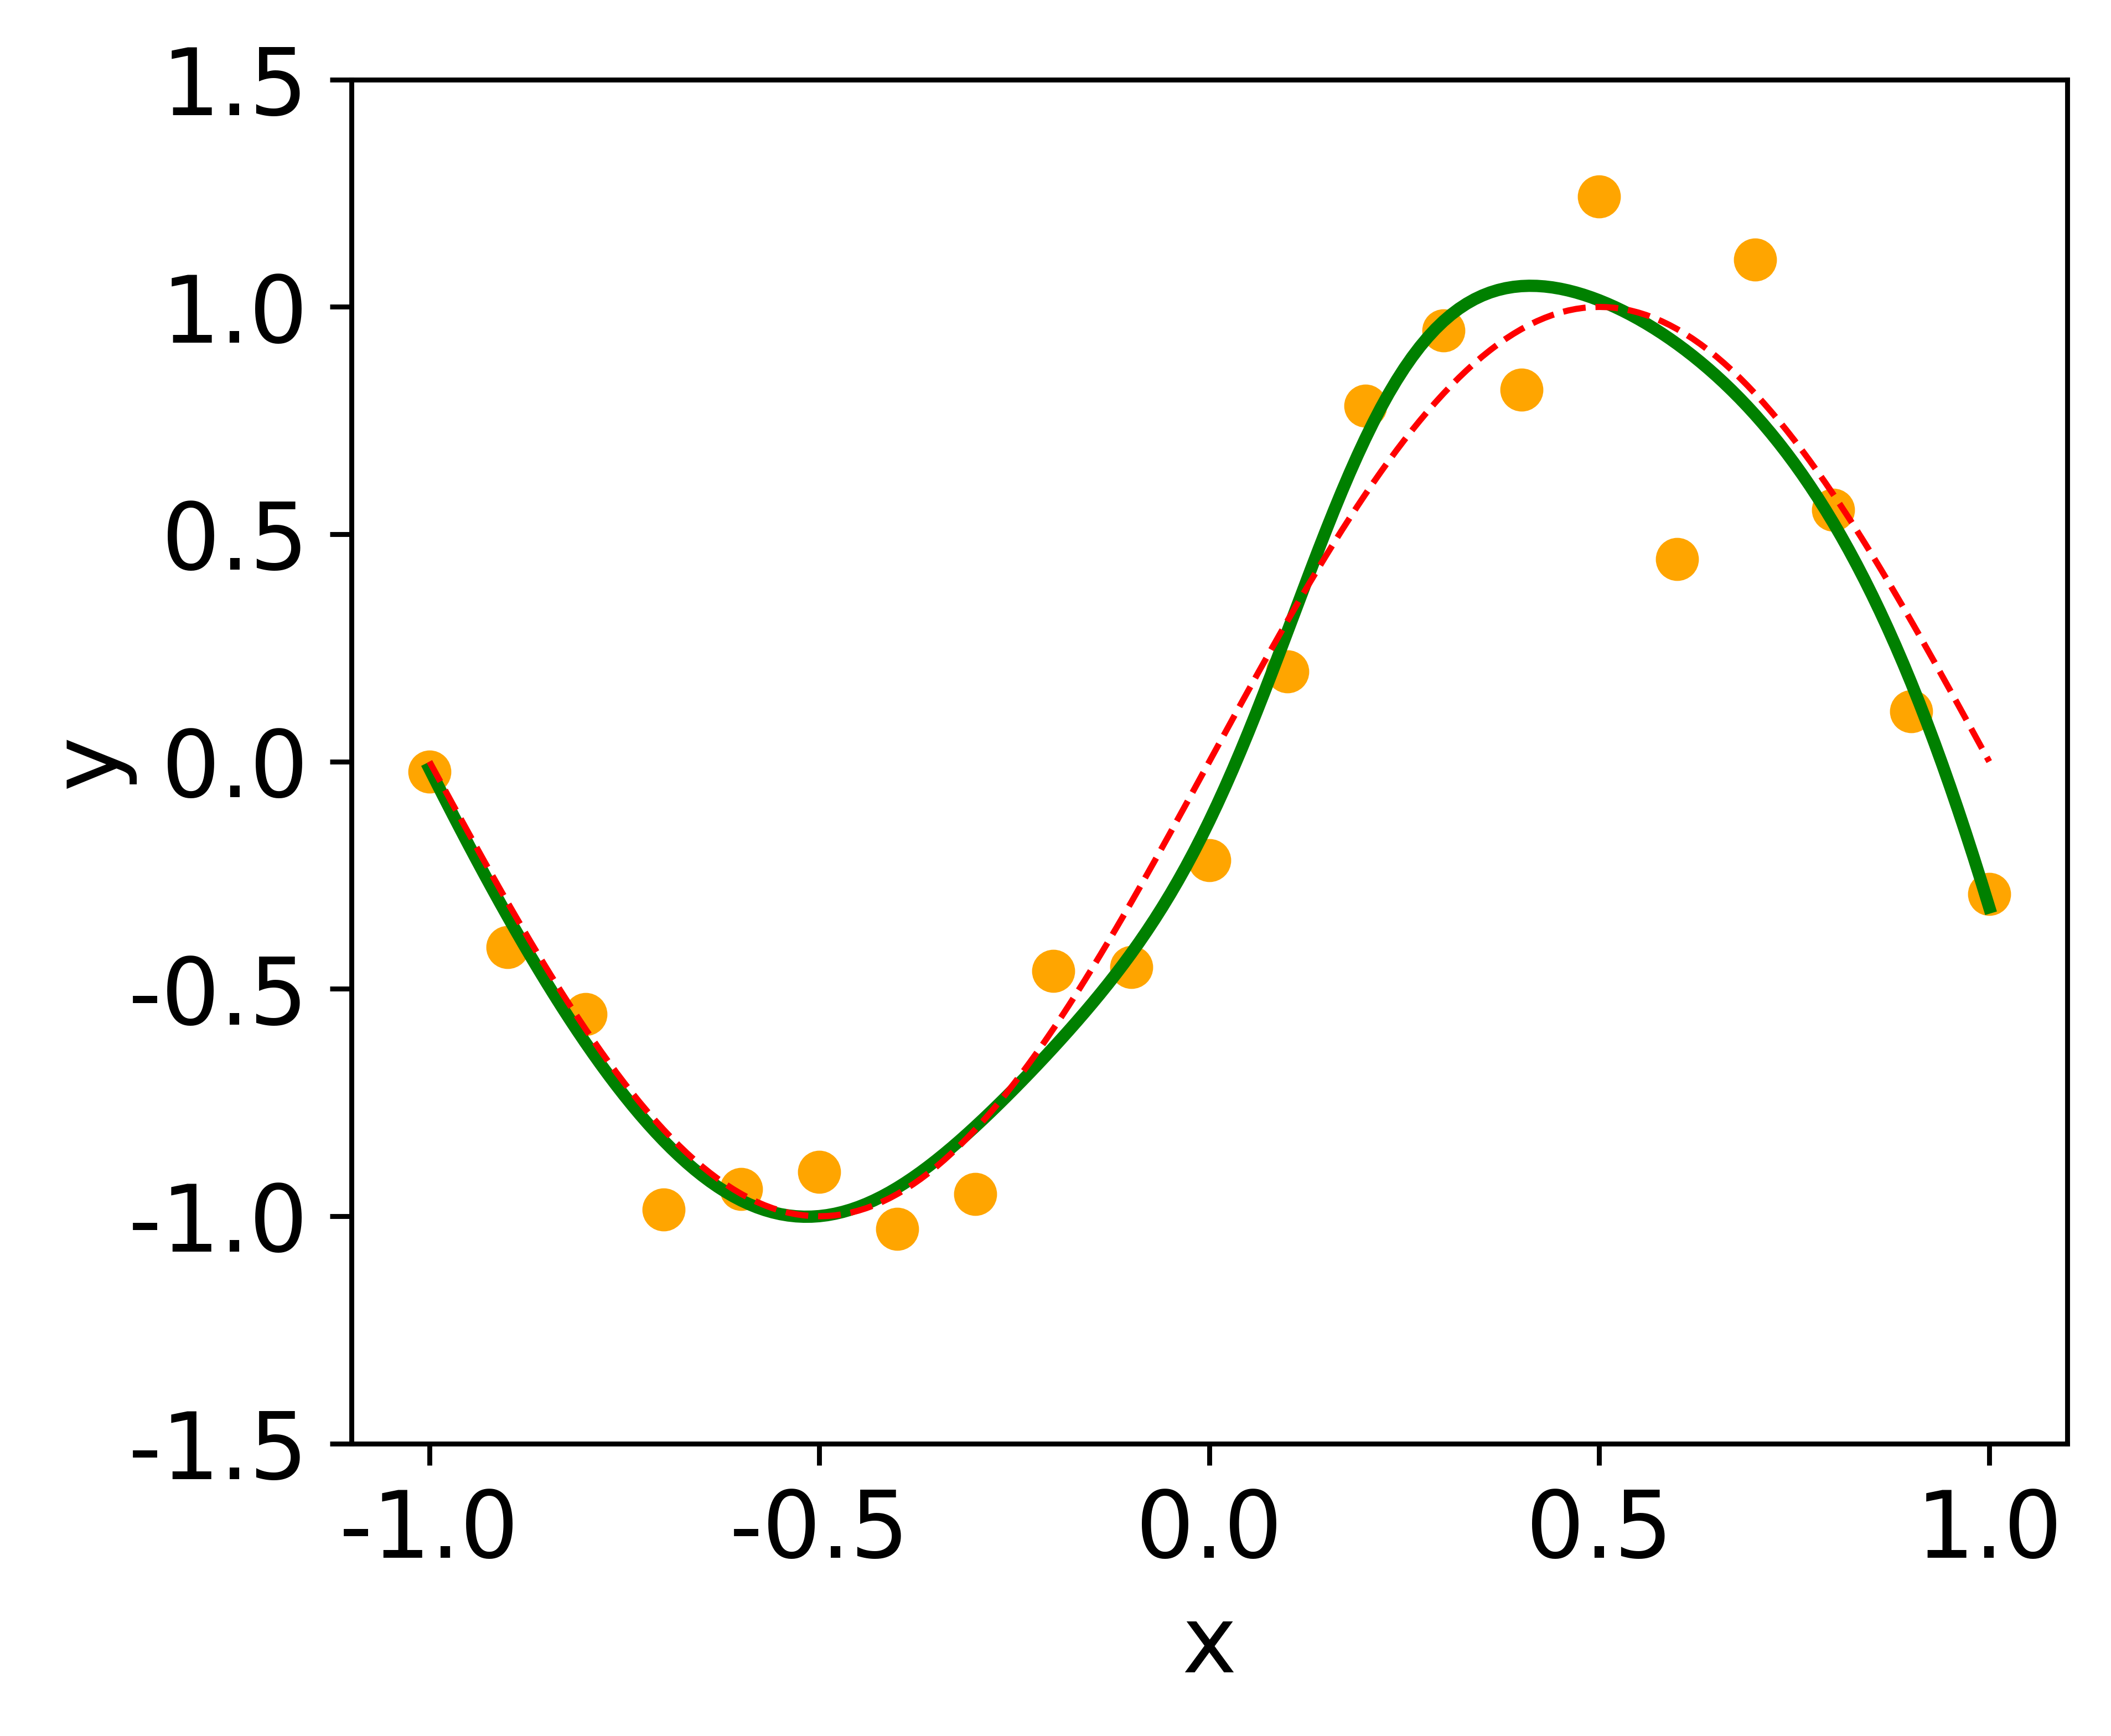

In [22]:
epoch = 20000#训练次数2万次
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录验证时函数的loss
std_dev=0.01#权系数上加噪声均方根大小
for t in range(epoch):
   
    prediction = net(x)  # 网络前向过程
    loss = loss_func(prediction, y) # 计算loss，通过prediction和y的差来计算mse
    para0[t] = loss.data
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    # 在更新参数之前，为每个参数添加高斯噪声
    for param in net.parameters():
        noise = torch.randn_like(param) * std_dev  # 标准高斯噪声乘以标准差
        param.data.add_(noise)
        
    optimizer.step()        # 更新参数！
##########################
#画出结果
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

tensor([0.5898, 0.5676, 0.5579,  ..., 0.0273, 0.0273, 0.0270])


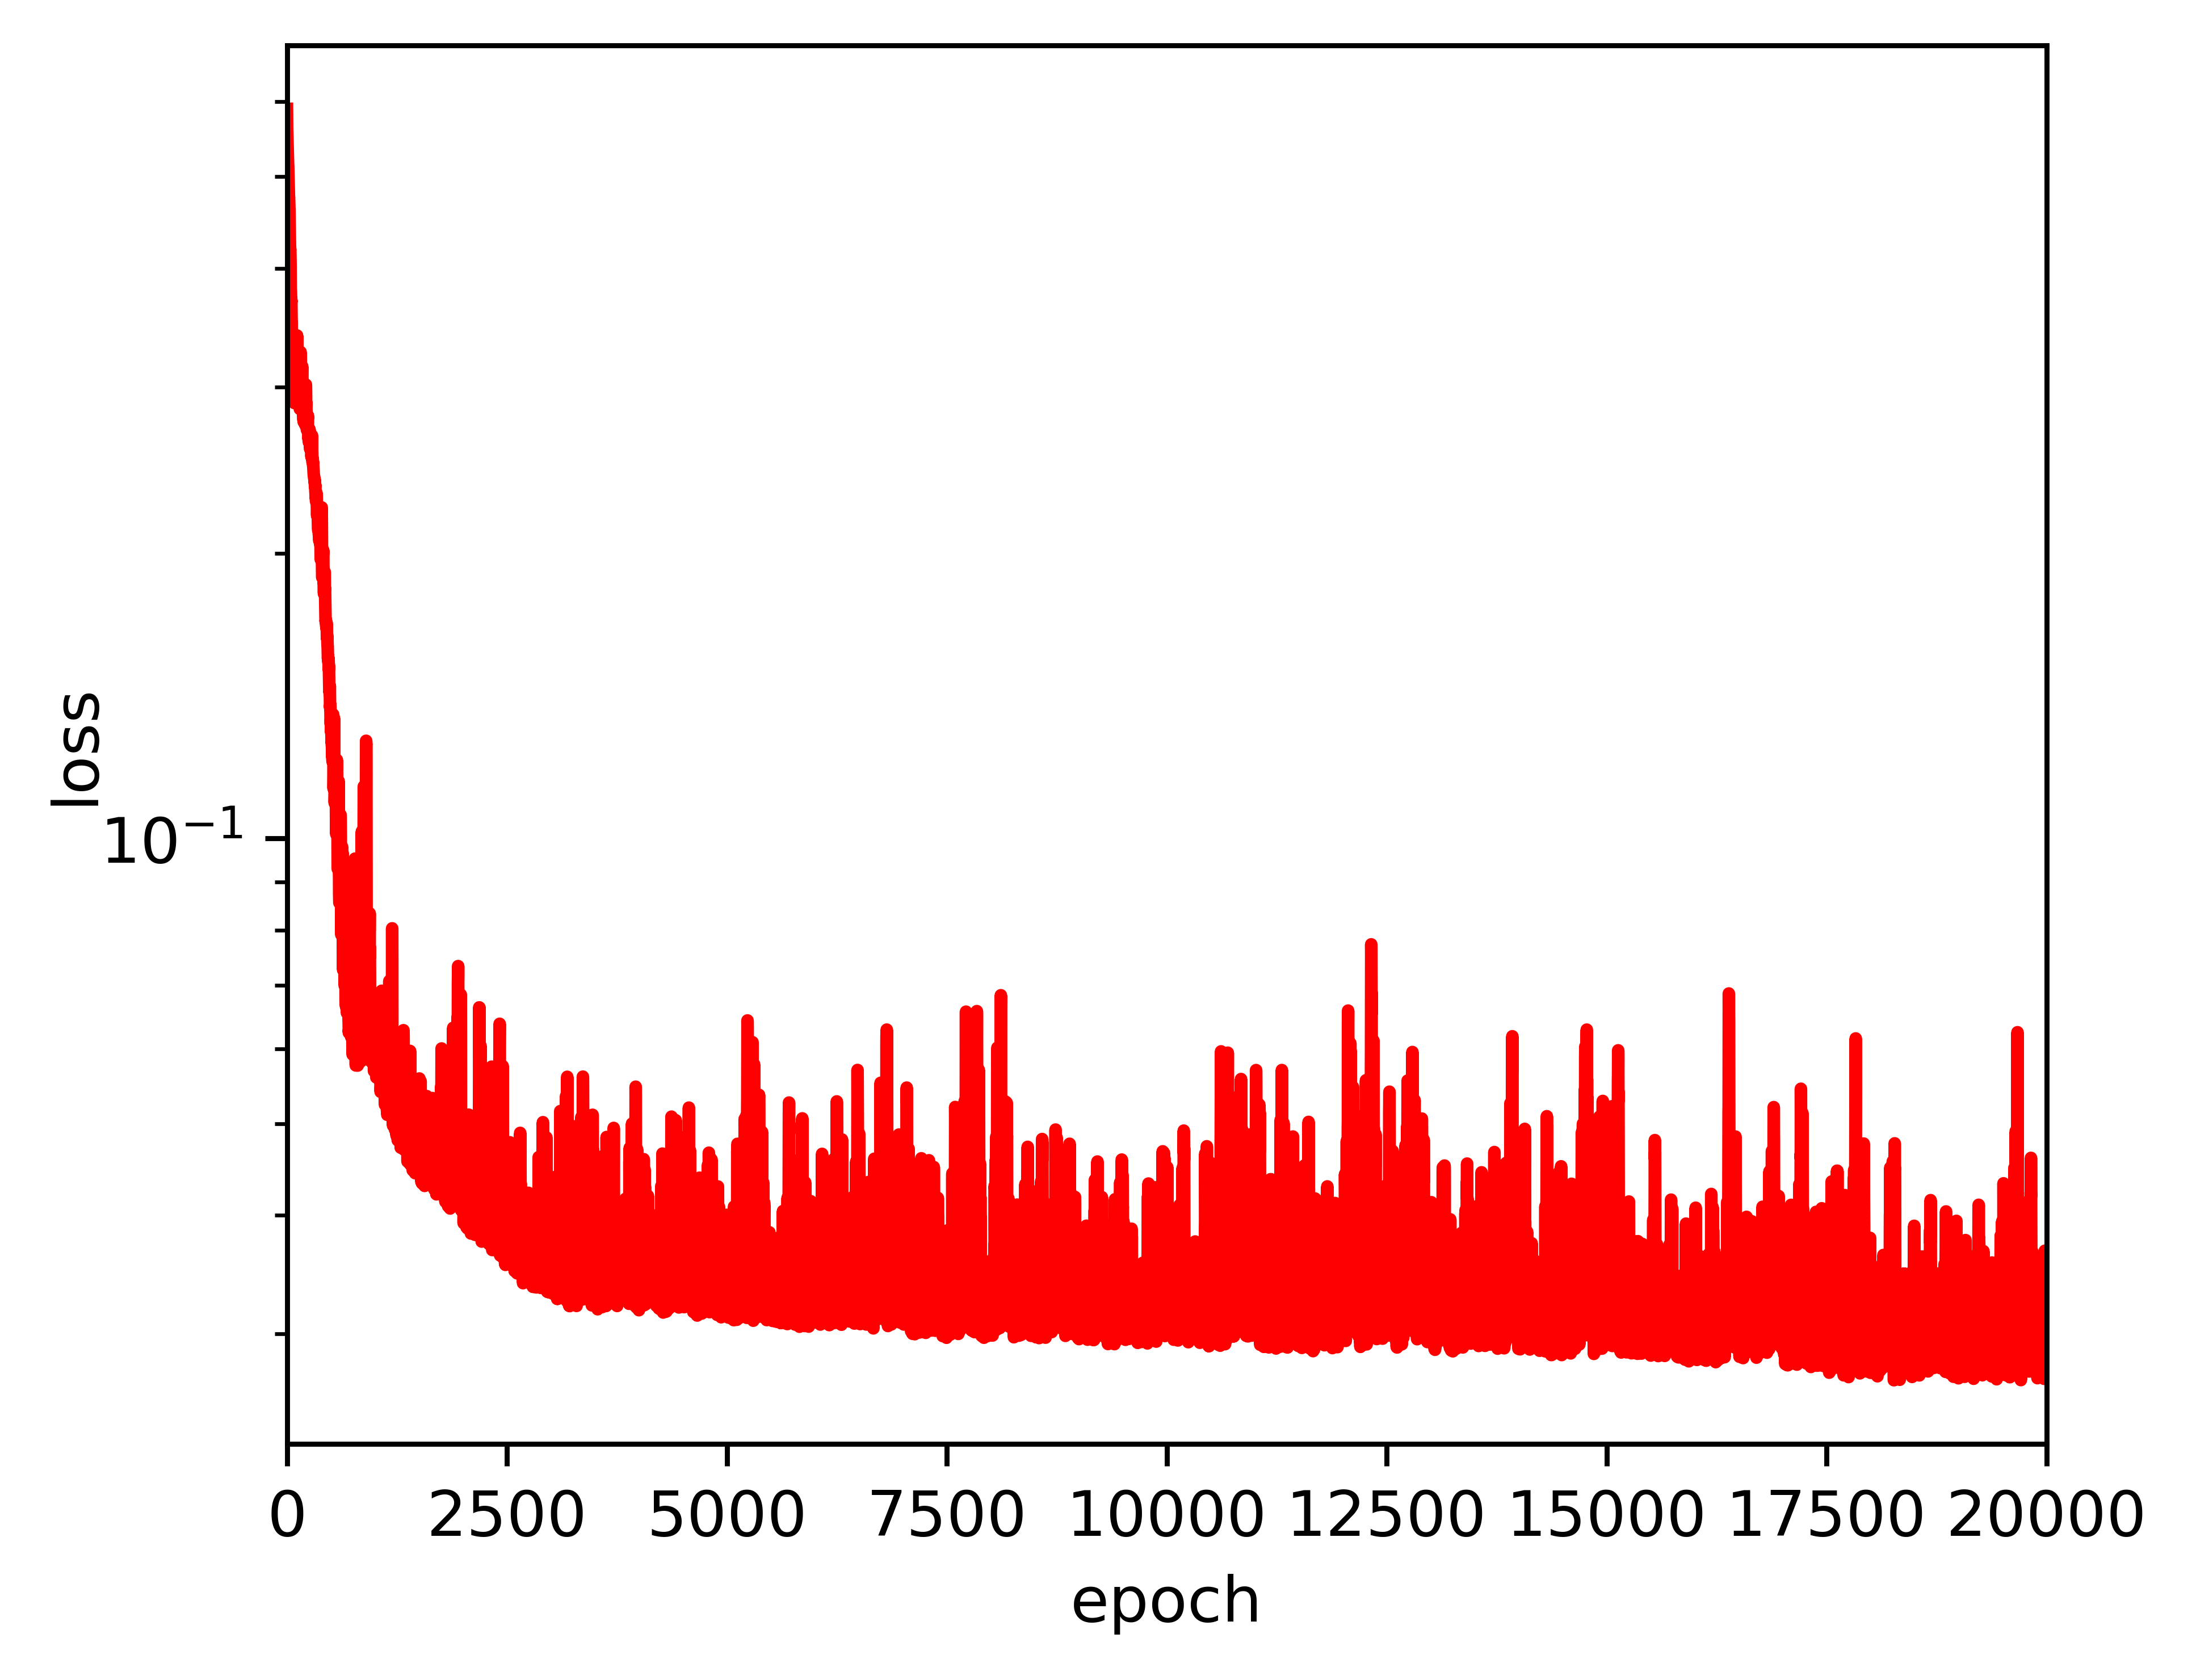

In [23]:
print(para0)#训练的MSE
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=10)
ax.set_xlabel('epoch', fontsize=10)
ax.set_ylabel('loss', fontsize=10, labelpad=-1)
ax.set_xlim(0, 20000)
ax.set_yscale('log')  # 设置y轴为对数坐标

ax.plot(para0.data.numpy(), 'r-', lw=2)
plt.show()

In [24]:
##############测试
SEED = 4321

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xx = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)#这里我们采样数目不一样
yy = torch.sin(math.pi*xx) + 0.2*torch.randn(xx.size())

prediction2 = net(xx)  # 前向过程
loss2 = loss_func(prediction2, yy)     # 计算loss，通过prediction和y的差来计算mse
print(loss2.data)# 

tensor(0.0433)


In [26]:
#效果还行，loss开始漂移，继续加大噪声为0.1

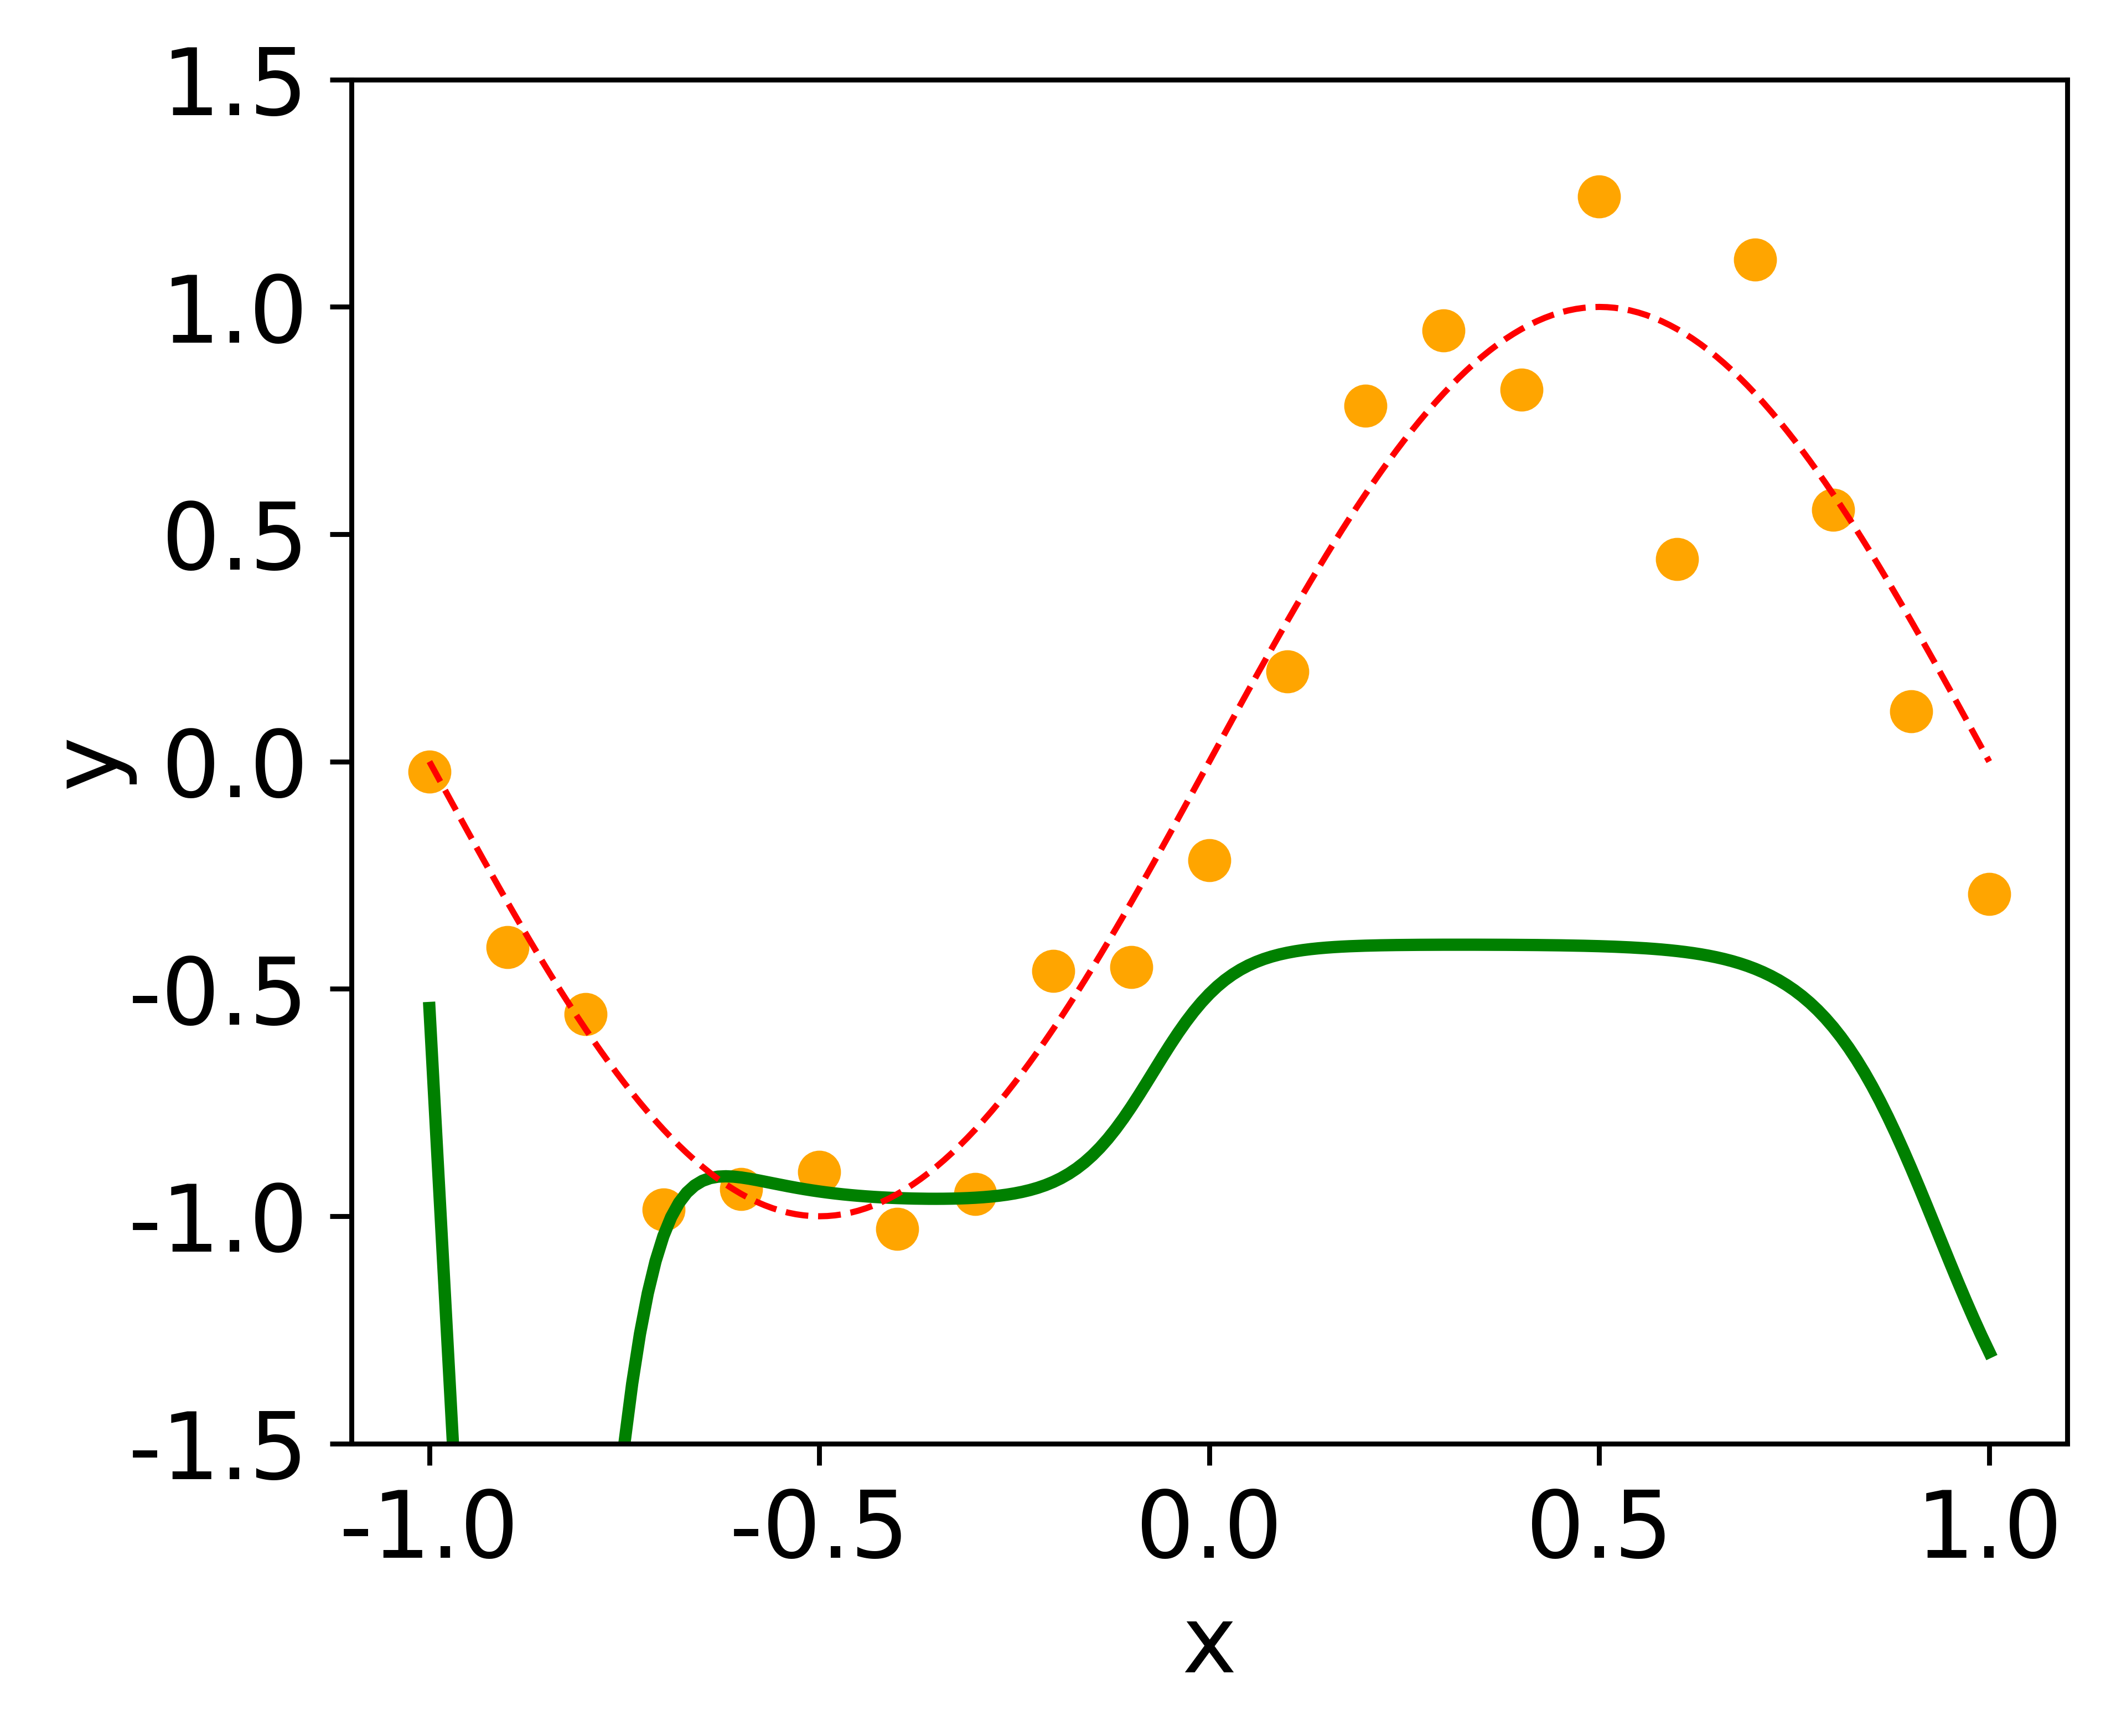

In [33]:
#权系数加噪声效果比加入数据中好！效果还行，当然不如我们设计激活函数
#继续调剂噪声强度比上面大10倍呢？
SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
y = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  # 这里是污染数据固定不变当成训练数据

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96

loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse
x = x.to(device)
y = y.to(device)#把数据都载入到device上

epoch = 20000#训练次数2万次
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录验证时函数的loss
std_dev=0.1#权系数上加噪声均方根大小
for t in range(epoch):
   
    prediction = net(x)  # 网络前向过程
    loss = loss_func(prediction, y) # 计算loss，通过prediction和y的差来计算mse
    para0[t] = loss.data
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    # 在更新参数之前，为每个参数添加高斯噪声
    for param in net.parameters():
        noise = torch.randn_like(param) * std_dev  # 标准高斯噪声乘以标准差
        param.data.add_(noise)
        
    optimizer.step()        # 更新参数！
##########################
#画出结果
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [34]:
##############测试
SEED = 4321

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xx = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)#这里我们采样数目不一样
yy = torch.sin(math.pi*xx) + 0.2*torch.randn(xx.size())

prediction2 = net(xx)  # 前向过程
loss2 = loss_func(prediction2, yy)     # 计算loss，通过prediction和y的差来计算mse
print(loss2.data)# 

tensor(1.4170)


In [ ]:
print(para0)#训练的MSE
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=10)
ax.set_xlabel('epoch', fontsize=10)
ax.set_ylabel('loss', fontsize=10, labelpad=-1)
ax.set_xlim(0, 20000)
ax.set_yscale('log')  # 设置y轴为对数坐标

ax.plot(para0.data.numpy(), 'r-', lw=2)
plt.show()

tensor([0.5898, 0.5770, 0.5093,  ..., 1.2451, 1.4000, 1.2643])


In [31]:
#似乎loss就是0.027左右，测试就是0.04左右，权系数上加噪声变化不大，网络输出效果变好一些